# Part 1

In [42]:
import numpy as np
import json
import sys

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [3]:
def simulate_lasso_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]

In [58]:
n_simulations = 5
n_features = 1000
n_folds = 10
n_observations = [250, 500, 750]
test_observations = 300
sparsity_values = [0.75, 0.9, 0.95, 0.99]
rng = np.random.default_rng()

results = {}
for N in n_observations:
    print(f"N={N}")
    results[f"N={N}"] = {}
    for sparsity in sparsity_values:
        # Generates data
        print("Generating data..")
        X, y, beta = simulate_lasso_data(N+test_observations, n_features, rng, sparsity=sparsity)
        
        # Initialises lists where to store 
        # the results
        alpha_min_mse = np.zeros(n_simulations)
        alpha_1se_mse = np.zeros(n_simulations)
        coeffs_min = []
        coeffs_1se = []
        
        print("Running lasso regression..")
        for ix in range(n_simulations):            
            # Splits data into train and test set. Note that same data is used for
            # each iter in n_simulations, this is to speed up.
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_observations/(N+test_observations))
                
            # Fits the model and calculates the score based on the
            # training data
            lasso = LassoCV(cv=n_folds, random_state=0).fit(X_train,y_train)
            coeffs_min.append(lasso.coef_)
            alpha_min_mse[ix] = mse(y_test, lasso.predict(X_test))
            
            # Finds the alpha_1se, i.e. the larges alpha that produces
            # MSE within one std of the mean MSE for alpha_min
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]
                        
            # Refits model to the new alpha and computes the score based on
            # based on the training data
            lasso = Lasso(alpha=alpha_1se).fit(X_train, y_train)
            coeffs_1se.append(lasso.coef_)
            alpha_1se_mse[ix] = mse(y_test, lasso.predict(X_test))
            
        results[f"N={N}"][f"SPRSTY={sparsity}"] = {
            "min_alpha_mse_mean": np.mean(alpha_min_mse),
            "min_alpha_mse_std": np.std(alpha_min_mse),
            "1se_alpha_mse_mean": np.mean(alpha_1se_mse),
            "1se_alpha_mse_std": np.std(alpha_1se_mse),
            "min_coeffs": coeffs_min,
            "1se_coeffs": coeffs_1se,
            "beta": beta,
        }

N=250
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
N=500
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
N=750
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..
Generating data..
Running lasso regression..


Text(0.06, 0.5, 'MSE')

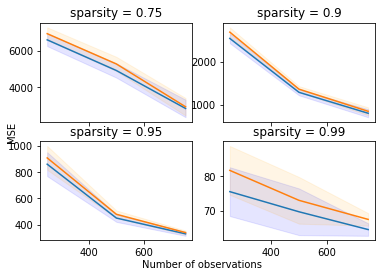

In [118]:
import matplotlib.pyplot as plt

if len(sparsity_values) != 4:
        raise Exception("For more than 4 sparsity value the number of subplots must be adjusted")
        
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
for ix, sparsity in enumerate(sparsity_values):
    # Plotting alpha_min and alpha_1se vs number of observations
    # for a given sparsity
    alpha_min_mse_mean_list = np.zeros(len(n_observations))
    alpha_1se_mse_mean_list = np.zeros(len(n_observations))
    alpha_min_mse_std_list = np.zeros(len(n_observations))
    alpha_1se_mse_std_list = np.zeros(len(n_observations))
    for jx, N in enumerate(n_observations):    
        alpha_min_mse_mean_list[jx] = results[f"N={N}"][f"SPRSTY={sparsity}"]["min_alpha_mse_mean"]
        alpha_1se_mse_mean_list[jx] = results[f"N={N}"][f"SPRSTY={sparsity}"]["1se_alpha_mse_mean"]
        alpha_min_mse_std_list[jx] = results[f"N={N}"][f"SPRSTY={sparsity}"]["min_alpha_mse_std"]
        alpha_1se_mse_std_list[jx] = results[f"N={N}"][f"SPRSTY={sparsity}"]["1se_alpha_mse_std"]
    
    ax = None
    if ix == 0:
        ax = ax1
    elif ix == 1:
        ax = ax2
    elif ix == 2:
        ax = ax3
    elif ix == 3:
        ax = ax4
    else:
        raise Exception("wtf :(")
    
    ax.plot(n_observations, alpha_min_mse_mean_list)
    ax.fill_between(n_observations, (alpha_min_mse_mean_list-alpha_min_mse_std_list), (alpha_min_mse_mean_list+alpha_min_mse_std_list), color='b', alpha=.1)
    ax.plot(n_observations, alpha_1se_mse_mean_list)
    ax.fill_between(n_observations, (alpha_1se_mse_mean_list-alpha_min_mse_std_list), (alpha_1se_mse_mean_list+alpha_min_mse_std_list), color='orange', alpha=.1)
    ax.set_title(f"sparsity = {sparsity}")
fig.text(0.5, 0.04, 'Number of observations', ha='center', va='center')
fig.text(0.06, 0.5, 'MSE', ha='center', va='center', rotation='vertical') 
    